In [1]:
#Import de librerías necesarias
import pyreadr
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
from sklearn import *
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import random
import time
import pandas as pd
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from scipy.stats import mannwhitneyu
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from collections import defaultdict

In [2]:
#Importar los datos de R a Python
datos = pyreadr.read_r('area_desbalance_ionico.RData')

#Para comprobar que se importan correctamente los datos
#print(datos.keys())

#Este archivo tiene tres variables

#datos_anon_D: datos extraídos de los ECGS - edad, sexo, fecha, hora y 
#nombre del fichero. Hay un código (código) que identifica a cada paciente
datos_anon_DF = datos['datos_anon_DF']

#lead_anon_DF
#variables electrocardiográficas correspondiente a los ECGs de la variable anterior
leads_anon_DF = datos['leads_anon_DF']

#pacs_con_ECGs_DF
#variables de los datos del potasio, fecha de la analítica, edad del paciente, sexo
#nivel de K y código del paciente
pacs_con_ECGs_DF = datos['pacs_con_ECGs_DF']

# Normalidad - Hiperpotasemia - Hipopotasemia

In [3]:
#Primer paso: coger solo los valores de K normales y de hiperpotasemia
k_val = pacs_con_ECGs_DF.copy()

limites = [float('-inf'), 3.5, 5.2, float('inf')]
etiquetas = [1, 0, 2]

In [4]:
k_valores = k_val.copy()

k_valores['categoria'] = pd.cut(k_valores['K'], bins=limites, labels=etiquetas, right=False)

#Se reemplazan los sexos por enteros
#1: Hombre
#0: Mujer
k_valores['Sexo'] = k_valores['Sexo'].replace({'M': 1, 'F': 0})

In [5]:
limites = [0, 30, 50, 70, 90, 110]
etiquetas = ['10-30', '31-50', '51-70', '71-90', '91-110']
k_valores['GrupoEdad'] = pd.cut(k_valores['Edad'], bins=limites, labels=etiquetas, right=False)

# Eliminación de variables con datos vacíos

In [6]:
#En leads_anon_DF, se van a eliminar aquellas columnas en las que falte más del 1% de los datos

#El como máximo (el 100%) de datos que podría tener cada característica, sería igual al número total de filas que
#hay registradas
#Se calcula el 10% y se redondea sin decimales
diez_pct_datos = round(len(leads_anon_DF) * 0.01, 0)

#Ahora, se va a coger un subconjunto del dataframe en el que se eliminan las
#características cuyo número de datos sea menor al 10%

#Se cuenta el número de NaN o celdas sin datos en cada columna
celdas_sin_datos = leads_anon_DF.isnull().sum()

#Se cogen las características cuyo número de datos vacíos es mayor o igual al 10%
caracteristicas_eliminar = celdas_sin_datos[celdas_sin_datos >= diez_pct_datos].index

#Se crear el subDataFrame eliminando las columnas correspondientes
leads_anon_DF_limpio = leads_anon_DF.drop(columns = caracteristicas_eliminar)

In [7]:
#Ahora hay que asociar a cada análisis de sangre, su ECG más cercano
def ECG_mas_reciente(fecha, codigo):
     
    archivos_ECGs = datos_anon_DF.loc[(datos_anon_DF['codigo'] == codigo) & (datos_anon_DF['date'] >= (fecha - timedelta(days=5))) & (datos_anon_DF['date'] <= (fecha + timedelta(days=5)))]    
    
    fechas_archivos = archivos_ECGs['date']
    horas_archivos = archivos_ECGs['time']
        
    diferencia_temporal = [abs(fecha - fecha_archivo) for fecha_archivo in fechas_archivos]
    
    ecg = (datos_anon_DF.index[(datos_anon_DF['codigo'] == codigo) & (datos_anon_DF['date'] >= (fecha - timedelta(days=5))) & (datos_anon_DF['date'] <= (fecha + timedelta(days=5)))]).tolist()
    
    if(len(diferencia_temporal) > 0):
    
        combinado = list(zip(diferencia_temporal, ecg))
        combinado = sorted(combinado, key=lambda x: x[0])

        diferencia_temporal, ecg = zip(*combinado)
        
    return ecg, diferencia_temporal

In [8]:
#Ahora, se añade la columna "Categoria" y "Sexo" a leads_anon_DF_limpio
#Se crean esas columnas en el nuevo dataframe con valores a Nan
leads_anon_DF_limpio['Sexo'] = float('NaN')
leads_anon_DF_limpio['categoria'] = float('NaN')
leads_anon_DF_limpio['K'] = float('NaN')
leads_anon_DF_limpio['Edad'] = float('NaN')
leads_anon_DF_limpio['GrupoEdad'] = float('NaN')

ecgs_utilizadas = {} 

for i in range(len(k_valores)):
    fecha_hora = (k_valores['Fecha'].iloc[i]).to_pydatetime()
    fecha = fecha_hora.date()
    
    indice, dist_temporal = ECG_mas_reciente(fecha, k_valores['codigo'].iloc[i])
  
    for j in range(len(indice)):
        #Si el ECGs no tiene una analítica asignada, se le pone
        if indice[j] not in ecgs_utilizadas:
            #Se actualizan los valores de las columnas "Sexo" y "Categoría"
            #de la fila correspondiente
            leads_anon_DF_limpio.at[indice[j], 'Sexo'] = k_valores['Sexo'].iloc[i]
            leads_anon_DF_limpio.at[indice[j], 'Edad'] = k_valores['Edad'].iloc[i]
            leads_anon_DF_limpio.at[indice[j], 'GrupoEdad'] = k_valores['GrupoEdad'].iloc[i]
            leads_anon_DF_limpio.at[indice[j], 'categoria'] = k_valores['categoria'].iloc[i]
            leads_anon_DF_limpio.at[indice[j], 'K'] = k_valores['K'].iloc[i]

            ecgs_utilizadas[indice[j]] = [k_valores['categoria'].iloc[i], dist_temporal[j].days]

        #Si el ECG ya tiene una analítica asociada, si la nueva analítica tiene un valor
        #de categoría diferente y se asocia con una anormalidad, se cambia
        else:
            if((dist_temporal[j].days < ecgs_utilizadas[indice[j]][1])):
                leads_anon_DF_limpio.at[indice[j], 'categoria'] = k_valores['categoria'].iloc[i]
                leads_anon_DF_limpio.at[indice[j], 'K'] = k_valores['K'].iloc[i]
                ecgs_utilizadas[indice[j]][1] = dist_temporal[j].days
                
            if((dist_temporal[j].days == ecgs_utilizadas[indice[j]][1]) & (k_valores['categoria'].iloc[i] > ecgs_utilizadas[indice[j]][0])):
                leads_anon_DF_limpio.at[indice[j], 'categoria'] = k_valores['categoria'].iloc[i]
                leads_anon_DF_limpio.at[indice[j], 'K'] = k_valores['K'].iloc[i]
                ecgs_utilizadas[indice[j]][1] = dist_temporal[j].days                
            
#Se eliminan las filas que tengan la variable objetivo "categoria" a NaN
leads_anon_DF_limpio = leads_anon_DF_limpio.dropna(subset=['categoria'])

# CARGA DE DATOS FINALIZADA

In [147]:
print(f'Analíticas normalidad: {(k_valores["categoria"] == 0).sum()}')
print(f'Analíticas hipopotasemia: {(k_valores["categoria"] == 1).sum()}')
print(f'Analíticas hiperpotasemia: {(leads_anon_DF_limpio["categoria"] == 2).sum()}')
print(f'Analíticas normalidad: {(leads_anon_DF_limpio["categoria"] == 0).sum()}')
print(f'Analíticas hipopotasemia: {(leads_anon_DF_limpio["categoria"] == 1).sum()}')
print(f'Analíticas hiperpotasemia: {(leads_anon_DF_limpio["categoria"] == 2).sum()}')

Analíticas normalidad: 1763
Analíticas hipopotasemia: 260
Analíticas hiperpotasemia: 750
Analíticas normalidad: 1544
Analíticas hipopotasemia: 189
Analíticas hiperpotasemia: 750


# Eliminación de características anormales

In [113]:
pct_datos = round(len(leads_anon_DF_limpio) * 0.3, 0)

#Ahora, se va a coger un subconjunto del dataframe en el que se eliminan las
#características cuyo número de datos sea menor al 10%

#Se cuenta el número de NaN o celdas sin datos en cada columna
celdas_sin_datos = leads_anon_DF_limpio.eq(0).sum()

#Se cogen las características cuyo número de datos vacíos es mayor o igual al 10%
caracteristicas_eliminar = celdas_sin_datos[celdas_sin_datos >= pct_datos].index

car_raras = leads_anon_DF_limpio[caracteristicas_eliminar]
car_rars_norm = car_raras[car_raras['categoria'] == 0] 
car_rars_hipo = car_raras[car_raras['categoria'] == 1] 
car_rars_hiper = car_raras[car_raras['categoria'] == 2] 
(car_rars_norm != 0).sum().to_excel('car_rars_norm.xlsx', index=True)
(car_rars_hipo != 0).sum().to_excel('car_rars_hipo.xlsx', index=True)
(car_rars_hiper != 0).sum().to_excel('car_rars_hiper.xlsx', index=True)

media = round(np.mean((car_raras.eq(0).sum()) / len(car_raras) * 100), 2)
print(f'Media de datos a 0 en las caracteristicas raras: {media}%')

Media de datos a 0 en las caracteristicas raras: 83.01%


In [75]:
cars = ['II_ppamp', 'II_rpamp', 'II_spamp', 'II_tpamp', 
       'II_pparea', 'II_tparea', 'II_rpdur', 'II_spdur', 'II_tpdur']


for i in range(len(cars)):
    hipo = (leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 0)| (leads_anon_DF_limpio['categoria'] == 1)]['categoria'])
    hiper = (leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 0)| (leads_anon_DF_limpio['categoria'] == 2)]['categoria'])
    
    car = leads_anon_DF_limpio[[cars[i]]].dropna()
    car[cars[i]] = car[cars[i]].apply(lambda x: 1 if x != 0 else 0)
    car_val = car[cars[i]]

    tabla_hipo = pd.crosstab(hipo, car_val)
    tabla_hiper = pd.crosstab(hiper, car_val)
    chi_hipo, p_hipo, _, _ = chi2_contingency(tabla_hipo)
    chi_hiper, p_hiper, _, _ = chi2_contingency(tabla_hiper)
    
    print('---------------------------------')
    print(f'{cars[i]} - Hipo')
    print(tabla_hipo)
    print(f"Estadístico de chi cuadrado: {chi_hipo}")
    print(f"Valor p: {p_hipo}")
    print('---------------------------------')
    print(f' ')
    print(f'{cars[i]} - Hiper')
    print(tabla_hiper)
    print(f"Estadístico de chi cuadrado: {chi_hiper}")
    print(f"Valor p: {p_hiper}")
    print('---------------------------------')
    print(f' ')

---------------------------------
II_ppamp - Hipo
II_ppamp      0    1
categoria           
0.0        1349  195
1.0         175   14
Estadístico de chi cuadrado: 3.8514374060995196
Valor p: 0.049703377366694876
---------------------------------
 
II_ppamp - Hiper
II_ppamp      0    1
categoria           
0.0        1349  195
2.0         636  103
Estadístico de chi cuadrado: 0.6428097376632359
Valor p: 0.4226951781535875
---------------------------------
 
---------------------------------
II_rpamp - Hipo
II_rpamp      0   1
categoria          
0.0        1511  33
1.0         182   7
Estadístico de chi cuadrado: 1.203460142300485
Valor p: 0.2726312025132292
---------------------------------
 
II_rpamp - Hiper
II_rpamp      0   1
categoria          
0.0        1511  33
2.0         722  17
Estadístico de chi cuadrado: 0.009277202711106814
Valor p: 0.9232678276738733
---------------------------------
 
---------------------------------
II_spamp - Hipo
II_spamp      0   1
categoria        

In [78]:
x = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] != 2]
y = x['categoria'].astype(int)

estratificacion_log = x[['categoria', 'Sexo']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=estratificacion_log)

arbol = DecisionTreeClassifier(class_weight="balanced")

cars = ['II_ppamp', 'II_pparea']

for i in range(len(cars)):
    train = x_train[[cars[i]]].dropna()
    test = x_test[[cars[i]]].dropna()
    train[cars[i]] = train[cars[i]].apply(lambda x: 1 if x != 0 else 0)
    test[cars[i]] = test[cars[i]].apply(lambda x: 1 if x != 0 else 0)

    arbol.fit(train, y_train)
    pred_prob = arbol.predict_proba(test)
    print(f"AUC: {roc_auc_score(y_test, pred_prob[:, 1], average=None)}")

AUC: 0.5171606199965934
AUC: 0.5303185147334355


In [148]:
pparea = leads_anon_DF_limpio.filter(regex='_pparea', axis=1)
tparea = leads_anon_DF_limpio.filter(regex='_tparea', axis=1)

ppamp = leads_anon_DF_limpio.filter(regex='_ppamp', axis=1)
rpamp = leads_anon_DF_limpio.filter(regex='_rpamp', axis=1)
spamp = leads_anon_DF_limpio.filter(regex='_spamp', axis=1)
tpamp = leads_anon_DF_limpio.filter(regex='_tpamp', axis=1)

rpdur = leads_anon_DF_limpio.filter(regex='_rpdur', axis=1)
spdur = leads_anon_DF_limpio.filter(regex='_spdur', axis=1)
tpdur = leads_anon_DF_limpio.filter(regex='_tpdur', axis=1)

leads_anon_DF_limpio = leads_anon_DF_limpio.drop(columns=pparea.columns)
leads_anon_DF_limpio = leads_anon_DF_limpio.drop(columns=tparea.columns)
leads_anon_DF_limpio = leads_anon_DF_limpio.drop(columns=ppamp.columns)
leads_anon_DF_limpio = leads_anon_DF_limpio.drop(columns=rpamp.columns)
leads_anon_DF_limpio = leads_anon_DF_limpio.drop(columns=spamp.columns)
leads_anon_DF_limpio = leads_anon_DF_limpio.drop(columns=tpamp.columns)
leads_anon_DF_limpio = leads_anon_DF_limpio.drop(columns=rpdur.columns)
leads_anon_DF_limpio = leads_anon_DF_limpio.drop(columns=spdur.columns)
leads_anon_DF_limpio = leads_anon_DF_limpio.drop(columns=tpdur.columns)

---

# Estadística descriptiva

### Casos por sexo

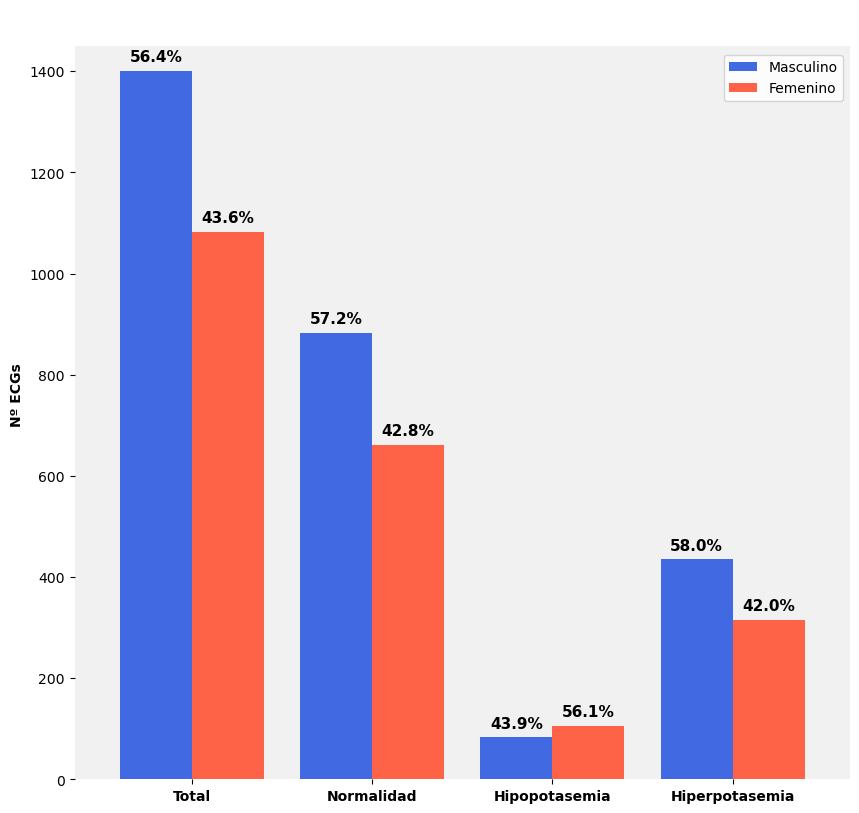

In [115]:
total_h = leads_anon_DF_limpio[leads_anon_DF_limpio['Sexo'] == 1]
total_m = leads_anon_DF_limpio[leads_anon_DF_limpio['Sexo'] == 0]

h_norm = total_h[total_h['categoria'] == 0]
h_hipo = total_h[total_h['categoria'] == 1]
h_hiper = total_h[total_h['categoria'] == 2]

m_norm = total_m[total_m['categoria'] == 0]
m_hipo = total_m[total_m['categoria'] == 1]
m_hiper = total_m[total_m['categoria'] == 2]

recuento = {
    'Masculino': [len(total_h), len(h_norm), len(h_hipo), len(h_hiper)],
    'Femenino': [len(total_m), len(m_norm), len(m_hipo), len(m_hiper)],
}
recuento_df = pd.DataFrame(recuento, index=['Total', 'Normalidad', 'Hipopotasemia', 'Hiperpotasemia'])

colores = ['royalblue', 'tomato']
ax = recuento_df.plot(kind='bar', figsize=(10, 10), width=0.8, color=colores)

plt.ylabel('Nº ECGs', fontweight='bold')
plt.xticks(rotation=0, fontweight='bold')

for idx, p in enumerate(ax.patches):
    # Calcular el porcentaje relativo a cada grupo (Masculino o Femenino)
    total_grupo = sum(recuento_df.iloc[idx%4])  # Total de cada grupo (Masculino o Femenino)
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_grupo)
    
    # Añadir la etiqueta al gráfico
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=11,  fontweight='bold')
    
plt.axhspan(-0, 1450, facecolor='lightgray', alpha=0.3, zorder=-1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)    

plt.legend(loc='upper right', bbox_to_anchor=(1, 0.95))
plt.show()

### Casos por edad

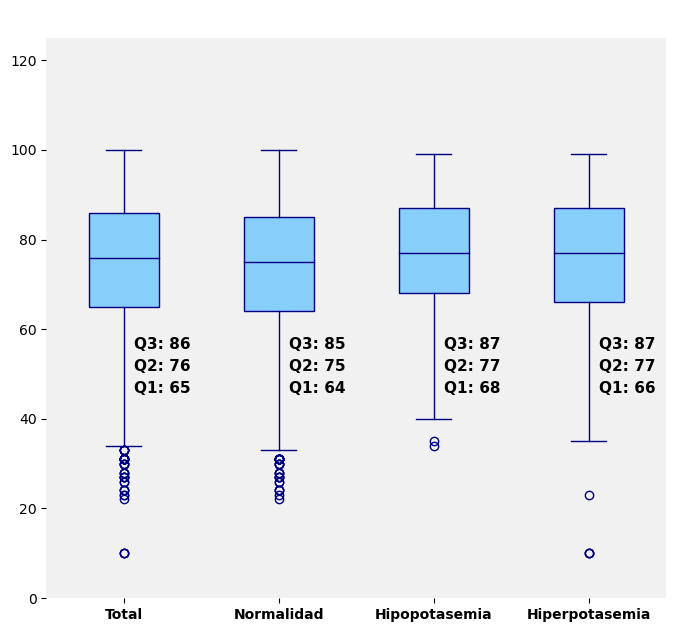

In [116]:
total = leads_anon_DF_limpio['Edad']
normalidad = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['Edad']
hipo = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 1]['Edad']
hiper = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 2]['Edad']

datos = [total, normalidad, hipo, hiper]

plt.figure(figsize=(8, 8))
plt.axhspan(0, 125, facecolor='lightgray', alpha=0.3)
plt.boxplot(datos, patch_artist=True, boxprops=dict(facecolor="lightskyblue", color='navy'), capprops=dict(color='navy'), whiskerprops=dict(color="navy"),
            flierprops=dict(color='navy', markeredgecolor='navy'), medianprops=dict(color='navy'))

plt.gca().spines['bottom'].set_position(('outward', -20))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

for i in range(4):
    q1 = int(np.percentile(datos[i], 25))
    median = int(np.percentile(datos[i], 50))
    q3 = int(np.percentile(datos[i], 75))
    
    # Coordenadas para colocar las etiquetas fuera de las cajas
    x_coord = i + 1
    y_offset = -25  # Ajuste vertical para separar las etiquetas del boxplot
    
    # Añadir texto con los cuantiles
    plt.text(x_coord+0.25, y_offset+70, f'Q1: {q1}', ha='center', va='bottom', color='black', fontsize=11, fontweight='bold')
    plt.text(x_coord+0.25, y_offset+80, f'Q3: {q3}', ha='center', va='bottom', color='black', fontsize=11, fontweight='bold')
    plt.text(x_coord+0.25, y_offset+75, f'Q2: {median}', ha='center', va='bottom', color='black', fontsize=11, fontweight='bold')
    
plt.xticks([1, 2, 3, 4], ['Total', 'Normalidad', 'Hipopotasemia', 'Hiperpotasemia'], fontweight='bold')
    
plt.show()

### Dsitribución según la concentración de potasio

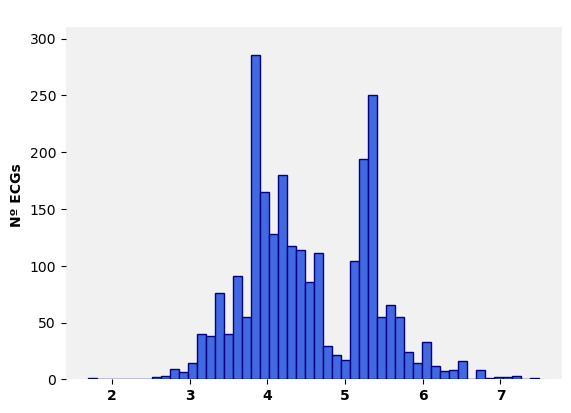

In [117]:
potasio = leads_anon_DF_limpio['K']

plt.hist(potasio, bins=50, edgecolor='navy', color='royalblue')
plt.axhspan(0, 310, facecolor='lightgray', alpha=0.3, zorder=-1)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.ylabel('Nº ECGs', fontweight='bold')
plt.xticks(fontweight='bold')

plt.show()

---

# Test de diferencias

## Variables categóricas - chi-cuadrado

### Sexo

In [118]:
potasio = leads_anon_DF_limpio['categoria']

tabla = pd.crosstab(potasio, leads_anon_DF_limpio['Sexo'])
chi2, p, _, _ = chi2_contingency(tabla)

In [119]:
tabla

Sexo,0.0,1.0
categoria,,
0.0,661,883
1.0,106,83
2.0,315,435


#### Normalidad

In [133]:
total = leads_anon_DF_limpio
total['categoria'] = total['categoria'].apply(lambda x: 1 if x > 0 else 0)

tabla = pd.crosstab(total['categoria'], total['Sexo'])
chi2, p, _, _ = chi2_contingency(tabla)

print(tabla)
print(f"Estadístico de chi cuadrado: {chi2}")
print(f"Valor p: {p}")

Sexo       0.0  1.0
categoria          
0          661  883
1          421  518
Estadístico de chi cuadrado: 0.8923171818472151
Valor p: 0.3448501451980126


#### Hipopotasemia

In [120]:
potasio = (leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 0)| (leads_anon_DF_limpio['categoria'] == 1)]['categoria'])
norm = leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 0)]
hipo = leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 1)]

tabla = pd.crosstab(potasio, leads_anon_DF_limpio['Sexo'])
chi2, p, _, _ = chi2_contingency(tabla)

print(tabla)
print(f"Estadístico de chi cuadrado: {chi2}")
print(f"Valor p: {p}")

Sexo       0.0  1.0
categoria          
0.0        661  883
1.0        106   83
Estadístico de chi cuadrado: 11.494052530573605
Valor p: 0.0006981923990354837


In [121]:
h_norm = len(norm[norm['Sexo'] == 1])
h_hipo = len(hipo[hipo['Sexo'] == 1])
m_norm = len(norm[norm['Sexo'] == 0])
m_hipo = len(hipo[hipo['Sexo'] == 0])

print(f'Riesgo relativo: {((m_hipo)/(m_hipo+m_norm))/((h_hipo)/(h_hipo+h_norm))}')

Riesgo relativo: 1.6084572972463516


#### Hiperpotasemia

In [122]:
potasio = (leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 0)| (leads_anon_DF_limpio['categoria'] == 2)]['categoria'])
norm = leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 0)]
hiper = leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 2)]

tabla = pd.crosstab(potasio, leads_anon_DF_limpio['Sexo'])
chi2, p, _, _ = chi2_contingency(tabla)

print(tabla)
print(f"Estadístico de chi cuadrado: {chi2}")
print(f"Valor p: {p}")

Sexo       0.0  1.0
categoria          
0.0        661  883
2.0        315  435
Estadístico de chi cuadrado: 0.10463819173161724
Valor p: 0.7463330610460206


In [123]:
h_norm = len(norm[norm['Sexo'] == 1])
h_hiper = len(hiper[hiper['Sexo'] == 1])
m_norm = len(norm[norm['Sexo'] == 0])
m_hiper = len(hiper[hiper['Sexo'] == 0])

print(f'Riesgo relativo: {((m_hiper)/(m_hiper+m_norm))/((h_hiper)/(h_hiper+h_norm))}')

Riesgo relativo: 0.9778829847371395


### Edad

#### Normalidad

In [136]:
total = leads_anon_DF_limpio
total['categoria'] = total['categoria'].apply(lambda x: 1 if x > 0 else 0)

tabla = pd.crosstab(total['categoria'], total['GrupoEdad'])
chi2, p, _, _ = chi2_contingency(tabla)

print(tabla)
print(f"Estadístico de chi cuadrado: {chi2}")
print(f"Valor p: {p}")

GrupoEdad  10-30  31-50  51-70  71-90  91-110
categoria                                    
0             14    117    439    785     189
1              4     41    241    508     145
Estadístico de chi cuadrado: 18.595279246720995
Valor p: 0.0009436785987967774


In [137]:
proporcion = tabla.div(tabla.sum(axis=0), axis=1)
proporcion.iloc[1]

GrupoEdad
10-30     0.222222
31-50     0.259494
51-70     0.354412
71-90     0.392885
91-110    0.434132
Name: 1, dtype: float64

#### Hipopotasemia

In [124]:
potasio = (leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 0)| (leads_anon_DF_limpio['categoria'] == 1)]['categoria'])
norm = leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 0)]
hipo = leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 1)]

tabla = pd.crosstab(potasio, leads_anon_DF_limpio['GrupoEdad'])
chi2, p, _, _ = chi2_contingency(tabla)

print(tabla)
print(f"Estadístico de chi cuadrado: {chi2}")
print(f"Valor p: {p}")

GrupoEdad  10-30  31-50  51-70  71-90  91-110
categoria                                    
0.0           14    117    439    785     189
1.0            0      8     42    113      26
Estadístico de chi cuadrado: 9.578391823500375
Valor p: 0.048161154545178615


In [125]:
proporcion = tabla.div(tabla.sum(axis=0), axis=1)
proporcion.iloc[1]

GrupoEdad
10-30     0.000000
31-50     0.064000
51-70     0.087318
71-90     0.125835
91-110    0.120930
Name: 1.0, dtype: float64

#### Hiperpotasemia

In [126]:
potasio = (leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 0)| (leads_anon_DF_limpio['categoria'] == 2)]['categoria'])
norm = leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 0)]
hiper = leads_anon_DF_limpio[(leads_anon_DF_limpio['categoria'] == 2)]

tabla = pd.crosstab(potasio, leads_anon_DF_limpio['GrupoEdad'])
chi2, p, _, _ = chi2_contingency(tabla)

print(tabla)
print(f"Estadístico de chi cuadrado: {chi2}")
print(f"Valor p: {p}")

GrupoEdad  10-30  31-50  51-70  71-90  91-110
categoria                                    
0.0           14    117    439    785     189
2.0            4     33    199    395     119
Estadístico de chi cuadrado: 14.616613676962363
Valor p: 0.005566153710679231


In [127]:
proporcion = tabla.div(tabla.sum(axis=0), axis=1)
proporcion.iloc[1]

GrupoEdad
10-30     0.222222
31-50     0.220000
51-70     0.311912
71-90     0.334746
91-110    0.386364
Name: 2.0, dtype: float64

---

## Variables continuas (artículo)

### Hipopotasemia

#### Menor amplitud de onda T

In [9]:
_, p_valor_n = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_tamp'])
_, p_valor_h = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 1]['II_tamp'])

print(f'p-valor normalidad: {p_valor_n}')
print(f'p-valor hipopotasemia: {p_valor_h}')

p-valor normalidad: 0.0009999999999998899
p-valor hipopotasemia: 0.010372323659776589


In [149]:
norm = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_tamp']
hipo = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 1]['II_tamp']

_, p_valor = mannwhitneyu(norm, hipo, nan_policy='omit')
print(f'P-valor: {p_valor}')
print(f'Media normalidad: {np.median(norm)}')
print(f'Media hipopotasemia: {np.median(hipo)}')

P-valor: 8.843516927574766e-05
Media normalidad: 135.0
Media hipopotasemia: 89.0


#### Depresión del segmento ST

In [171]:
_, p_valor_n = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_stslope'])
_, p_valor_h = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 1]['II_stslope'])

print(f'p-valor normalidad: {p_valor_n}')
print(f'p-valor hipopotasemia: {p_valor_h}')

p-valor normalidad: 0.0009999999999998899
p-valor hipopotasemia: 0.0009999999999998899


In [153]:
norm = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_stmid']
hipo = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 1]['II_stmid']

_, p_valor = mannwhitneyu(norm, hipo)
print(f'P-valor: {p_valor}')
print(f'Media normalidad: {np.median(norm)}')
print(f'Media hipopotasemia: {np.median(hipo)}')

P-valor: 1.2708996299106165e-06
Media normalidad: 14.0
Media hipopotasemia: -8.0


#### Maior duración de QRS

In [ ]:
_, p_valor_n = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_qrsdur'])
_, p_valor_h = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 1]['II_qrsdur'])

print(f'p-valor normalidad: {p_valor_n}')
print(f'p-valor hipopotasemia: {p_valor_h}')

In [154]:
norm = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_qrsdur']
hipo = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 1]['II_qrsdur']

_, p_valor = mannwhitneyu(norm, hipo)
print(f'P-valor: {p_valor}')
print(f'Media normalidad: {np.median(norm)}')
print(f'Media hipopotasemia: {np.median(hipo)}')

P-valor: 0.6669055706218838
Media normalidad: 90.0
Media hipopotasemia: 92.0


#### Maior amplitude de P

In [ ]:
_, p_valor_n = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_qrsdur'])
_, p_valor_h = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 1]['II_qrsdur'])

print(f'p-valor normalidad: {p_valor_n}')
print(f'p-valor hipopotasemia: {p_valor_h}')

In [156]:
norm = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_pamp']
hipo = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 1]['II_pamp']

_, p_valor = mannwhitneyu(norm, hipo)
print(f'P-valor: {p_valor}')
print(f'Media normalidad: {np.median(norm)}')
print(f'Media hipopotasemia: {np.median(hipo)}')

P-valor: 0.0013083476249772744
Media normalidad: 90.0
Media hipopotasemia: 70.0


In [160]:
norm = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_pamp']
hipo = leads_anon_DF_limpio[leads_anon_DF_limpio['K'] <= 2.5]['II_pamp']

_, p_valor = mannwhitneyu(norm, hipo)
print(f'P-valor: {p_valor}')
print(f'Media normalidad: {np.median(norm)}')
print(f'Media hipopotasemia: {np.median(hipo)}')

P-valor: 0.3929149189318092
Media normalidad: 90.0
Media hipopotasemia: 50.0


1

---

### Hiperpotasemia

#### Ondas T más altas, picudas y anchas en la base

In [189]:
_, p_valor_n = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_tamp'])
_, p_valor_h = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 2]['II_tamp'])

print(f'p-valor normalidad: {p_valor_n}')
print(f'p-valor hipopotasemia: {p_valor_h}')

p-valor normalidad: 0.0009999999999998899
p-valor hipopotasemia: 0.0009999999999998899


In [164]:
norm = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_tamp']
hipo = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 2]['II_tamp']

_, p_valor = mannwhitneyu(norm, hipo, nan_policy='omit')
print(f'P-valor: {p_valor}')
print(f'Media normalidad: {np.nanmedian(norm)}')
print(f'Media hiperpotasemia: {np.nanmedian(hipo)}')

P-valor: 0.3178609855118585
Media normalidad: 135.0
Media hiperpotasemia: 139.0


#### Menor amplitud de la onda P

In [198]:
_, p_valor_n = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['V2_pamp'])
_, p_valor_h = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 2]['V2_pamp'])

print(f'p-valor normalidad: {p_valor_n}')
print(f'p-valor hipopotasemia: {p_valor_h}')

p-valor normalidad: 0.0009999999999998899
p-valor hipopotasemia: 0.0009999999999998899


In [166]:
norm = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_pamp']
hipo = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 2]['II_pamp']

_, p_valor = mannwhitneyu(norm, hipo, nan_policy='omit')
print(f'P-valor: {p_valor}')
print(f'Media normalidad: {np.nanmedian(norm)}')
print(f'Media hipopotasemia: {np.nanmedian(hipo)}')

P-valor: 0.44160645180664193
Media normalidad: 90.0
Media hipopotasemia: 88.0


#### Depresión del segmento ST

In [182]:
_, p_valor_n = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_stmid'])
_, p_valor_h = sm.stats.diagnostic.lilliefors(leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 2]['II_stimd'])

print(f'p-valor normalidad: {p_valor_n}')
print(f'p-valor hiperpotasemia: {p_valor_h}')

p-valor normalidad: 0.0009999999999998899
p-valor hiperpotasemia: 0.0009999999999998899


In [167]:
norm = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 0]['II_stmid']
hipo = leads_anon_DF_limpio[leads_anon_DF_limpio['categoria'] == 2]['II_stmid']

_, p_valor = mannwhitneyu(norm, hipo, nan_policy='omit')
print(f'P-valor: {p_valor}')
print(f'Media normalidad: {np.nanmedian(norm)}')
print(f'Media hipopotasemia: {np.nanmedian(hipo)}')

P-valor: 0.6872113373962185
Media normalidad: 14.0
Media hipopotasemia: 10.0


---